In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
import numpy as np
from itertools import combinations

In [7]:
class OneVsOneClassifierCustom(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model=LogisticRegression):
        self.base_model = base_model
        self.models = []
        self.class_pairs = []

    def fit(self, X, y):
        self.models = []
        self.class_pairs = []

        # Obtener clases únicas
        classes = np.unique(y)
        
        # Crear combinaciones de pares (0 vs 1), (0 vs 2), ...
        for (c1, c2) in combinations(classes, 2):
            # Filtrar dataset por solo esas dos clases
            idx = np.where((y == c1) | (y == c2))
            X_pair = X[idx]
            y_pair = y[idx]

            # Modelo nuevo
            model = self.base_model()
            model.fit(X_pair, y_pair)

            self.models.append(model)
            self.class_pairs.append((c1, c2))
        
        return self

    def predict(self, X):
        votes = np.zeros((X.shape[0], len(self.class_pairs)))
        
        predictions = []
        for i, model in enumerate(self.models):
            preds = model.predict(X)
            votes[:, i] = preds
        
        # Voto mayoritario por fila
        final_preds = []
        for row in votes:
            counts = np.bincount(row.astype(int))
            final_preds.append(np.argmax(counts))
        
        return np.array(final_preds)

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:

# Cargar dataset
data = load_iris()
X, y = data.data, data.target

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Instanciar y entrenar
ovo = OneVsOneClassifierCustom()
ovo.fit(X_train, y_train)

# Predicción
y_pred = ovo.predict(X_test)

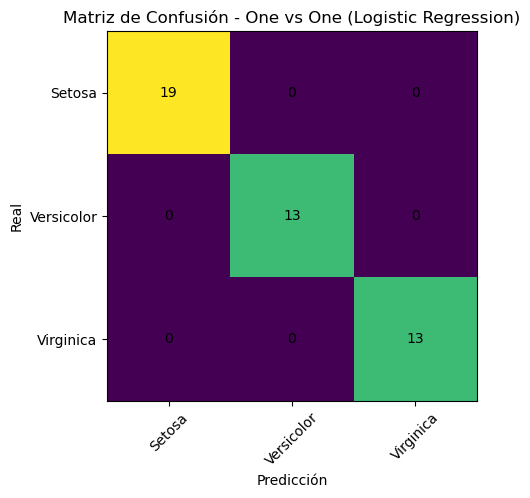

In [6]:
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Matriz de Confusión - One vs One (Logistic Regression)")
plt.xlabel("Predicción")
plt.ylabel("Real")

# Etiquetas de las clases (Iris)
clases = ["Setosa", "Versicolor", "Virginica"]
plt.xticks(np.arange(len(clases)), clases, rotation=45)
plt.yticks(np.arange(len(clases)), clases)

# Imprimir valores en cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.show()
